In [1]:
import numpy as np
from utils.database_repository import DataRepository
from utils.objects import *
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import time
from datetime import datetime
import inspect


In [2]:
repository = DataRepository()

Connected to MySQL Server version  5.7.39-42-log


In [25]:
# CONFIGURATION
min_temp = 0
max_temp = 200

min_battery = 40
max_battery = 80

between = 0
duration = 1

language = "CSharp"

env = "PROD"

limit = 200


## OS
windows_os = "Win32NT"
linux_os = "Unix"

os = [
    windows_os,
    # linux_os
    ]

## Test cases
idle_case = "TestCaseIdle"
dining_philosophers = "DiningPhilosophers"
binary_tress = "BinaryTrees"
reverse_complement = "ReverseComplement"
fannkuch_redux = "FannkuchRedux"
n_body = "Nbody"
fasta = "Fasta"

test_cases = [
    idle_case,
    # dining_philosophers,
    binary_tress,
    # # reverse_complement,
    # fannkuch_redux,
    # n_body,
    # fasta
]

## Profilers
intel_power_gadget = "IntelPowerGadget"
rapl = "RAPL"
hardware_monitor = "HardwareMonitor"
clamp = "Clamp"
e3 = "E3"


profilers = [
    intel_power_gadget,
    # rapl,
    hardware_monitor,
    clamp,
    # e3
]

## DUT
surface_pro_4 = "Surface4Pro"
surface_book = "SurfaceBook"
power_komplett = "PowerKomplett"

duts = [
    surface_pro_4,
    surface_book,
    power_komplett
]

dut_version = {
    surface_book : {
            windows_os : 6,
            linux_os : 1
        },
    surface_pro_4 : {
        windows_os : 12,
        linux_os : 1,
    },
    power_komplett : {
        windows_os : 8,
        linux_os : 1,
    }
}


## Types

package_total = "PackageInJoulesTotal"
dram_total = "DramInJoulesTotal"
core_total = "CoresInJoulesTotal"

comparison_types = [package_total, dram_total,core_total]


In [6]:
data = {}

for d in duts:
    data[d] = {}
    for o in os:
        version = dut_version[d][o]
        data[d][version] = {}
        data[d][version][o] = {}
        for t in test_cases:
            data[d][version][o][t] = {}
            for p in profilers:
                data[d][version][o][t][p] = {}
                data[d][version][o][t][p]["contains_data"] = False
                
                profiler = EnergyProfiler(p, repository)
                config = Configuration(min_temp, max_temp, min_battery, max_battery, duration, between, version, repository, env)
                dut = Dut(d, o, repository)
                test_case = TestCase(t, repository)
                
                if config.id > 0:
                    config_id = config.id
                    dut_id = dut.id
                    test_case_id = test_case.id
                    profiler_id = profiler.id
                    
                    experiment = Experiment(config_id, dut_id, test_case_id, profiler_id, language, repository, 200)
                    
                    if len(experiment.experiments) > 0:
                        print(f"success for {d}, {o}, {t}, {p}")
                        data[d][version][o][t][p]["config"] = config
                        data[d][version][o][t][p]["profiler"] = profiler
                        data[d][version][o][t][p]["dut"] = dut
                        data[d][version][o][t][p]["test_case"] = test_case
                        data[d][version][o][t][p]["experiment"] = experiment
                        data[d][version][o][t][p]["contains_data"] = True

success for Surface4Pro, Win32NT, TestCaseIdle, IntelPowerGadget
success for Surface4Pro, Win32NT, TestCaseIdle, HardwareMonitor
success for Surface4Pro, Win32NT, BinaryTrees, IntelPowerGadget
success for Surface4Pro, Win32NT, BinaryTrees, HardwareMonitor
success for SurfaceBook, Win32NT, TestCaseIdle, IntelPowerGadget
success for SurfaceBook, Win32NT, TestCaseIdle, HardwareMonitor
success for SurfaceBook, Win32NT, BinaryTrees, IntelPowerGadget
success for SurfaceBook, Win32NT, BinaryTrees, HardwareMonitor
success for PowerKomplett, Win32NT, TestCaseIdle, IntelPowerGadget
success for PowerKomplett, Win32NT, TestCaseIdle, HardwareMonitor
success for PowerKomplett, Win32NT, TestCaseIdle, Clamp
success for PowerKomplett, Win32NT, BinaryTrees, IntelPowerGadget
success for PowerKomplett, Win32NT, BinaryTrees, HardwareMonitor
success for PowerKomplett, Win32NT, BinaryTrees, Clamp


```python
data[current_dut][current_version][current_os][current_test_case][current_profiler]
```

In [7]:
repository.close()

In [22]:
# inspect.getmembers(experiment.experiments[0], lambda a:not(inspect.isroutine(a)))

In [36]:
exp = data[power_komplett][8][windows_os][idle_case][intel_power_gadget]["experiment"].experiments[0]

In [39]:
exp.duration, exp.runs, exp.duration / exp.runs 

(60090, 2, 30045.0)

### Dynamic Energy

Next up, the dynamic energy will be calculated. This will be the average energy consumption of the idle case.

In [101]:
dynamic_energy = {}

# data[d][v][o][t][p]["experiment"]

for d in duts:
    dynamic_energy[d] = {}
    for o in os:
        v = dut_version[d][o]
        dynamic_energy[d][v] = {}
        dynamic_energy[d][v][o] = {}
        for p in profilers:
            dynamic_energy[d][v][o][p] = {}
            for types in comparison_types:
                t = idle_case
                
                count, average, _, min_value, max_value, duration = get_consumption(d,v, o, p, t, types)
                dynamic_energy[d][v][o][p][types] = average
                dynamic_energy[d][v][o][p]["duration"] = duration
                print(f"{d} - {v} - {o} - {p} - {types} - {average} - {count} - {min_value} - {max_value} - {duration}")



Surface4Pro - 12 - Win32NT - IntelPowerGadget - PackageInJoulesTotal - 95.98967627941177 - 136 - 61.139404 - 667.71844 - 30086.066176470587
Surface4Pro - 12 - Win32NT - IntelPowerGadget - DramInJoulesTotal - 29.535156249999986 - 136 - 29.281921 - 33.59204 - 30086.066176470587
Surface4Pro - 12 - Win32NT - IntelPowerGadget - CoresInJoulesTotal - 95.98967627941177 - 136 - 61.139404 - 667.71844 - 30086.066176470587
Surface4Pro - 12 - Win32NT - HardwareMonitor - PackageInJoulesTotal - 49.71980046196019 - 136 - 23.602422580122948 - 398.4910373315215 - 30051.625
Surface4Pro - 12 - Win32NT - HardwareMonitor - DramInJoulesTotal - 28.59632083948921 - 136 - 28.377602443099022 - 29.667289569973946 - 30051.625
Surface4Pro - 12 - Win32NT - HardwareMonitor - CoresInJoulesTotal - 28.508995084239253 - 136 - 4.408531468361616 - 351.23742505162954 - 30051.625
Surface4Pro - 12 - Win32NT - Clamp - PackageInJoulesTotal - 0 - 0 - 0 - 0 - 0
Surface4Pro - 12 - Win32NT - Clamp - DramInJoulesTotal - 0 - 0 - 0 - 

In [104]:
def get_dynamic_energy(d, v, o, p, energy_type, duration, energy_consumption, per_unit=1000):
    dynamic_energy_index = dynamic_energy[d][v][o][p]

    dynamic_energy_consumption = dynamic_energy_index[energy_type]
    dynamic_duration = dynamic_energy_index["duration"]
    
    if dynamic_duration == 0 or duration == 0:
        return 0
    
    dynamic_energy_per_unit = (per_unit / dynamic_duration) * dynamic_energy_consumption
    energy_per_unit = (per_unit / duration) * energy_consumption
    
    return energy_per_unit - dynamic_energy_per_unit 

In [119]:
dynamic_energy_dut = power_komplett
dynamic_energy_os = windows_os
dynamic_energy_version = dut_version[dynamic_energy_dut][dynamic_energy_os]
dynamic_energy_profiler = intel_power_gadget
dynamic_energy_test_case = binary_tress
dynamic_energy_type = dram_total

In [120]:
_, energy_consumption, _, _, _, duration = get_consumption(dynamic_energy_dut,
                                                                    dynamic_energy_version, 
                                                                    dynamic_energy_os, 
                                                                    dynamic_energy_profiler, 
                                                                    dynamic_energy_test_case, 
                                                                    dynamic_energy_type)

dynamic_energy_consumption = get_dynamic_energy(d, v, o, p, dynamic_energy_type, duration, energy_consumption)
# dynamic_energy_consumption = get_dynamic_energy(d, v, o, p, dynamic_energy_type, duration, energy_consumption, per_unit=0.5716669904816651)

energy_consumption, duration, dynamic_energy_consumption

(-0.5082535284150248, 0.5716669904816651, -889.0727239415895)

In [221]:
data_to_inspect = data[power_komplett][8][windows_os][idle_case][intel_power_gadget]["experiment"].experiments[0].start_battery.data
inspect.getmembers(data_to_inspect, lambda a:not(inspect.isroutine(a)))

[]

### Intel Power Gadget

- CumulativeDramEnergyInJoules
- CumulativeGtEnergyInJoules
- CumulativeIaEnergyInJoules
- CumulativeProcessorEnergyInJoules

### Clamp

- TrueRMS
- ACRMSRAW

idle -  true: 3651, acr: 3612
fans - 600 - 700

### OpenHardwareMonitor

- cpuPowerPacketTotalJ
- cpuPowerCoresTotalJ
- cpuPowerMemoryTotalJ
- cpuPowerPacketAverageJ
- cpuPowerCoresAverageJ
- cpuPowerMemoryAverageJ

In [129]:
def plot_comparison(comparison_type):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    labels = []
    energy_consumption = []
    
    x = []
    y = []
    e = []


    i = 0

    for t in test_cases:
        if t != idle_case:
            for d in duts:
                for o in os:
                    for p in profilers:
                        version = dut_version[d][o]
                        
                        labels.append(f"h - {i}")
                        length, average, std, min_value, max_value, duration = get_consumption(d,version, o, p, t, comparison_type)
                        # dynamic_energy_consumption = get_dynamic_energy(d, version, o, p, comparison_type, duration, average)
                        # energy_consumption.append(dynamic_energy_consumption)
                        energy_consumption.append(average)
                        x.append(f"c {i}")
                        # y.append(dynamic_energy_consumption)
                        y.append(average)
                        e.append(std)
                        
                        print(f"{i} - {d}, {o}, {p}, {t} - sum of {length} ({min_value} - {max_value})")
                        i += 1

    plt.errorbar(x, y, e, linestyle='None', marker='.')
    plt.show()

0 - Surface4Pro, Win32NT, IntelPowerGadget, BinaryTrees - sum of 122 (9.699561483966681 - 12.75021977515838)
1 - Surface4Pro, Win32NT, HardwareMonitor, BinaryTrees - sum of 124 (11.157781461498026 - 14.11880520188684)
2 - Surface4Pro, Win32NT, Clamp, BinaryTrees - sum of 0 (0 - 0)
3 - SurfaceBook, Win32NT, IntelPowerGadget, BinaryTrees - sum of 127 (1.2670762584725308 - 5.172539407748209)
4 - SurfaceBook, Win32NT, HardwareMonitor, BinaryTrees - sum of 126 (1.515940938912102 - 6.473499540147198)
5 - SurfaceBook, Win32NT, Clamp, BinaryTrees - sum of 0 (0 - 0)
6 - PowerKomplett, Win32NT, IntelPowerGadget, BinaryTrees - sum of 120 (62.628393540093064 - 68.65525045290848)
7 - PowerKomplett, Win32NT, HardwareMonitor, BinaryTrees - sum of 120 (63.17983995511292 - 67.2996179398815)
8 - PowerKomplett, Win32NT, Clamp, BinaryTrees - sum of 120 (-8.510827833379064 - -8.510827833379064)


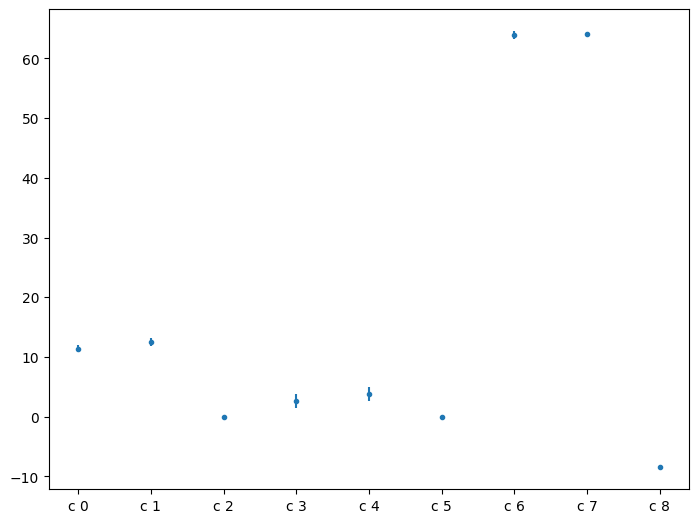

In [130]:
plot_comparison(package_total)


0 - Surface4Pro, Win32NT, IntelPowerGadget, BinaryTrees - sum of 122 (-0.49303426883930185 - -0.1657580136628798)
1 - Surface4Pro, Win32NT, HardwareMonitor, BinaryTrees - sum of 124 (-0.47700667494271803 - -0.11320933806136535)
2 - Surface4Pro, Win32NT, Clamp, BinaryTrees - sum of 0 (0 - 0)
3 - SurfaceBook, Win32NT, IntelPowerGadget, BinaryTrees - sum of 127 (-0.22643451504653822 - -0.03492015096362)
4 - SurfaceBook, Win32NT, HardwareMonitor, BinaryTrees - sum of 126 (-0.23111664944107302 - -0.022508258232816436)
5 - SurfaceBook, Win32NT, Clamp, BinaryTrees - sum of 0 (0 - 0)
6 - PowerKomplett, Win32NT, IntelPowerGadget, BinaryTrees - sum of 120 (-0.5325218635868817 - -0.11026808633390894)
7 - PowerKomplett, Win32NT, HardwareMonitor, BinaryTrees - sum of 120 (-0.5303438685384214 - -0.4329816769130834)
8 - PowerKomplett, Win32NT, Clamp, BinaryTrees - sum of 120 (0 - 0)


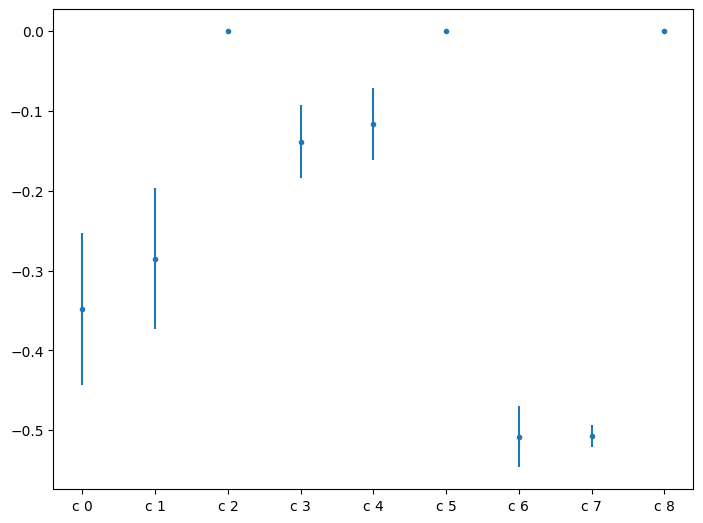

In [131]:
plot_comparison(dram_total)

0 - Surface4Pro, Win32NT, IntelPowerGadget, BinaryTrees - sum of 122 (9.699561483966681 - 12.75021977515838)
1 - Surface4Pro, Win32NT, HardwareMonitor, BinaryTrees - sum of 124 (10.844334061388246 - 12.222616294821524)
2 - Surface4Pro, Win32NT, Clamp, BinaryTrees - sum of 0 (0 - 0)
3 - SurfaceBook, Win32NT, IntelPowerGadget, BinaryTrees - sum of 127 (1.2670762584725308 - 5.172539407748209)
4 - SurfaceBook, Win32NT, HardwareMonitor, BinaryTrees - sum of 126 (1.3133641767411408 - 6.213910783042094)
5 - SurfaceBook, Win32NT, Clamp, BinaryTrees - sum of 0 (0 - 0)
6 - PowerKomplett, Win32NT, IntelPowerGadget, BinaryTrees - sum of 120 (62.628393540093064 - 68.65525045290848)
7 - PowerKomplett, Win32NT, HardwareMonitor, BinaryTrees - sum of 120 (64.08669133730693 - 68.19130097703922)
8 - PowerKomplett, Win32NT, Clamp, BinaryTrees - sum of 120 (-8.510827833379064 - -8.510827833379064)


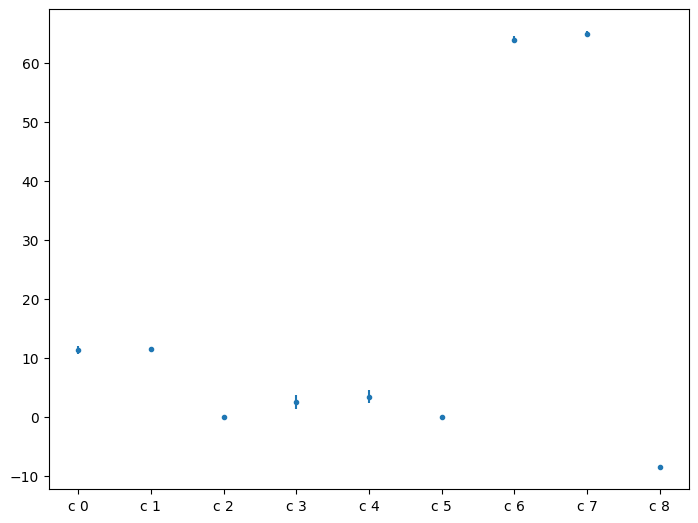

In [132]:
plot_comparison(core_total)


In [157]:
def default_func(exp, value):
    return True

def get_consumption(d, v, o, p, t, value_type, func_parameter, func=default_func):
    try:
        data_points = data[d][v][o][t][p]["experiment"].experiments
    except Exception as e:
        return 0, 0, 0, 0, 0, 0
    
    duration = [exp.duration / exp.runs for exp in data_points if func(exp, func_parameter)]
    length = len(duration)
    
    if value_type == package_total:
        if p == intel_power_gadget:
            values = [(x.CumulativeProcessorEnergyInJoules, x.duration) for x in data_points  if func(x, func_parameter)]
        elif p == clamp:
            values = [(x.TrueRMS, x.duration) for x in data_points]
        elif p == hardware_monitor:
            values = [(x.cpuPowerPacketTotalJ, x.duration) for x in data_points if func(x, func_parameter)]
        else:
            raise Exception(f"{p} not implemented")
    elif value_type == dram_total:
        if p == intel_power_gadget:
            values = [(x.CumulativeDramEnergyInJoules, x.duration) for x in data_points if func(x, func_parameter)]
        elif p == clamp:
            values = [(0, 0) for x in data_points]
        elif p == hardware_monitor:
            values = [(x.cpuPowerMemoryTotalJ, x.duration) for x in data_points if func(x, func_parameter)]
        else:
            raise Exception(f"{p} not implemented")
    elif value_type == core_total:
        if p == intel_power_gadget:
            values = [(x.CumulativeProcessorEnergyInJoules, x.duration) for x in data_points if func(x, func_parameter)]
        elif p == clamp:
            values = [(x.TrueRMS, x.duration) for x in data_points if func(x, func_parameter)]
        elif p == hardware_monitor:
            values = [(x.cpuPowerCoresTotalJ, x.duration) for x in data_points if func(x, func_parameter)]
        else:
            raise Exception(f"{p} not implemented")
    else:
        raise Exception(f"{value_type} not implmeneted")
    
    dynamic_values = []
    
    for value in values:
        dynamic_values.append(
            get_dynamic_energy(d, v, o, p, value_type, value[1], value[0])
            )
    
    if length == 0:
        return 0, 0, 0, 0, 0, 0
    
    
    return length, sum(dynamic_values) / length, np.std(dynamic_values), min(dynamic_values), max(dynamic_values), sum(duration) / length

In [168]:
def is_correct_first_profiler(exp, value):
    return exp.first_profiler == value

def plot_first_profiler_comparison(comparison_type):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    labels = []
    energy_consumption = []
    
    x = []
    y = []
    e = []

    i = 0

    for d in duts:
        for t in test_cases:
            if t != idle_case:
                for o in os:
                    for p in profilers:
                        for first_profiler in profilers:
                            # func = is_correct_first_profiler(first_profiler)
                            
                            version = dut_version[d][o]
                            
                            labels.append(f"h - {i}")
                            length, average, std, min_value, max_value, duration = get_consumption(d,version, o, p, t, comparison_type, first_profiler, func=is_correct_first_profiler)
                            energy_consumption.append(average)
                            
                            if not min_value == 0 and not max_value == 0:
                                x.append(f"c {i}")
                                y.append(average)
                                e.append(std)
                                
                                # print(f"{i} - {first_profiler}, {p}, {d}, {o}, {t} - sum of {length} ({min_value} - {max_value})")
                                print(f"{i} - {d}, {t}, {o}, {p}, {first_profiler} - sum of {length} ({min_value} - {max_value})")
                                i += 1

    plt.errorbar(x, y, e, linestyle='None', marker='.')
    plt.show()

0 - Surface4Pro, BinaryTrees, Win32NT, IntelPowerGadget, IntelPowerGadget - sum of 68 (9.699561483966681 - 12.75021977515838)
1 - Surface4Pro, BinaryTrees, Win32NT, IntelPowerGadget, HardwareMonitor - sum of 54 (10.209023847793171 - 12.744318013314507)
2 - Surface4Pro, BinaryTrees, Win32NT, HardwareMonitor, IntelPowerGadget - sum of 67 (11.677571651488847 - 14.027043029580954)
3 - Surface4Pro, BinaryTrees, Win32NT, HardwareMonitor, HardwareMonitor - sum of 57 (11.157781461498026 - 14.11880520188684)
4 - SurfaceBook, BinaryTrees, Win32NT, IntelPowerGadget, IntelPowerGadget - sum of 73 (1.337519417353373 - 5.172539407748209)
5 - SurfaceBook, BinaryTrees, Win32NT, IntelPowerGadget, HardwareMonitor - sum of 54 (1.2670762584725308 - 5.004002902371618)
6 - SurfaceBook, BinaryTrees, Win32NT, HardwareMonitor, IntelPowerGadget - sum of 71 (1.515940938912102 - 6.0025974493007235)
7 - SurfaceBook, BinaryTrees, Win32NT, HardwareMonitor, HardwareMonitor - sum of 55 (1.9849522923317129 - 6.473499540

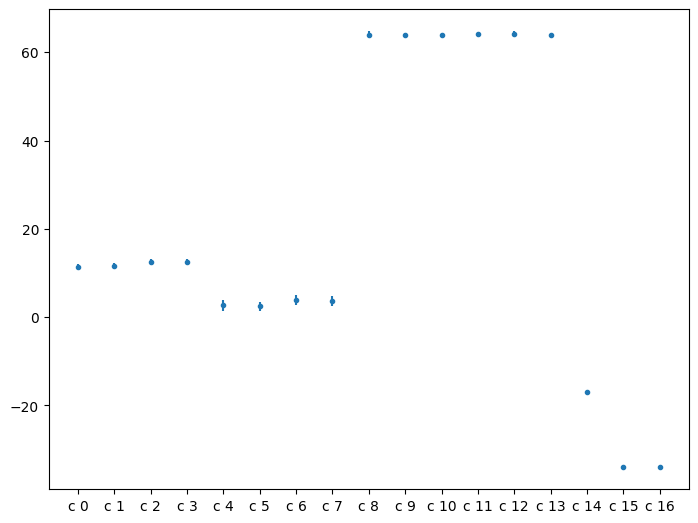

In [169]:
plot_first_profiler_comparison(package_total)

In [229]:
def plot_iterations(comparison_type, get_next_value, is_correct_value, xlabel, ylabel, label):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    for d in duts:
        for t in test_cases:
            if t != idle_case:
                for o in os:
                    for p in profilers:
                        if (p == clamp and d == power_komplett) or p != clamp:
                            print(f"{d}, {t}, {o}, {p}")
                            # x1 = []
                            # y1 = []
                            # for i in get_next_value():
                            #     version = dut_version[d][o]
                                
                            #     length, average, std, min_value, max_value, duration = get_consumption(d,version, o, p, t, comparison_type, i, func=is_correct_value)
                                
                            #     if min_value > 0 and max_value > 0 and average > 0 and length > 0:
                            #         x1.append(i)
                            #         y1.append(average)
                            # if len(y1) > 0:
                            #     print(f"{i} - {d}, {t}, {o}, {p} - sum of {len(y1)} ({min(y1)} - {max(y1)})")
                            # plt.plot(x1, y1, label = f"{p[0]} - {d[0]}{d[-1]} - {t[0]}")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(label)
    plt.legend()
    plt.show()

In [207]:
def get_iteration():
    for i in range(30):
        yield i
        
def is_correct_iteration(exp, value):
    return exp.iteration == value

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Surface4Pro, BinaryTrees, Win32NT, IntelPowerGadget
Surface4Pro, BinaryTrees, Win32NT, HardwareMonitor
Surface4Pro, BinaryTrees, Win32NT, Clamp
SurfaceBook, BinaryTrees, Win32NT, IntelPowerGadget
SurfaceBook, BinaryTrees, Win32NT, HardwareMonitor
SurfaceBook, BinaryTrees, Win32NT, Clamp
PowerKomplett, BinaryTrees, Win32NT, IntelPowerGadget
PowerKomplett, BinaryTrees, Win32NT, HardwareMonitor
PowerKomplett, BinaryTrees, Win32NT, Clamp


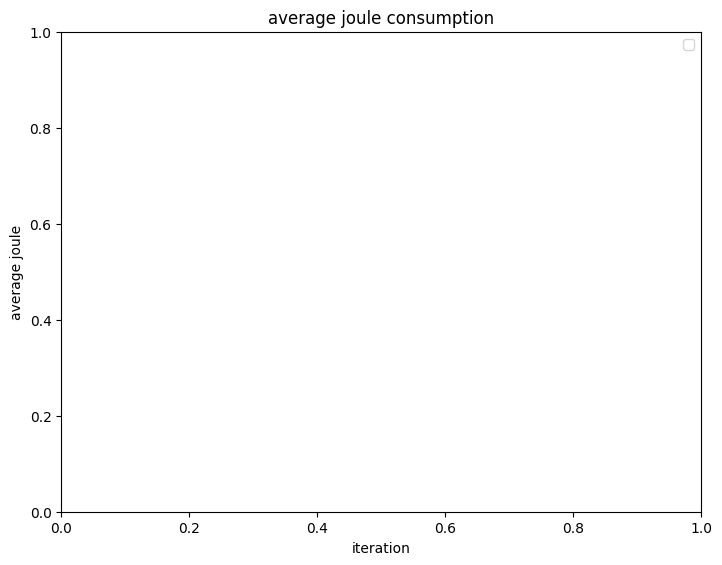

In [230]:
plot_iterations(core_total, get_iteration, is_correct_iteration, "iteration", "average joule", "average joule consumption")

In [209]:
def get_buckets():
    min_bucket = 0
    max_bucket = 100
    bucket_size = 5

    last_value = 0

    for i in range(min_bucket + bucket_size, max_bucket + 1, bucket_size):
        # print(f"min: {last_value}, max: {i}, between: {((i - last_value) / 2) + last_value}")
        yield (last_value, i)
        last_value = i

def is_correct_temperature(exp, value):
    min_value = value[0]
    max_value = value[1]
    
    temp = [x.value for x in exp.start_temperature.data]
    
    avg_temp = sum(temp) / len(temp)
    
    return avg_temp > min_value and avg_temp < max_value

(95, 100) - Surface4Pro, BinaryTrees, Win32NT, IntelPowerGadget - sum of 5 (10.281290159147513 - 11.483853815588512)
(95, 100) - Surface4Pro, BinaryTrees, Win32NT, HardwareMonitor - sum of 6 (10.928189804990994 - 12.135930137401157)
(95, 100) - SurfaceBook, BinaryTrees, Win32NT, IntelPowerGadget - sum of 5 (1.8767184164637851 - 3.4836717838856526)
(95, 100) - SurfaceBook, BinaryTrees, Win32NT, HardwareMonitor - sum of 3 (3.3738967988695983 - 3.510330006625164)
(95, 100) - PowerKomplett, BinaryTrees, Win32NT, IntelPowerGadget - sum of 2 (63.92741180410284 - 63.95916888141521)
(95, 100) - PowerKomplett, BinaryTrees, Win32NT, HardwareMonitor - sum of 5 (64.26948547808377 - 65.10858349328882)


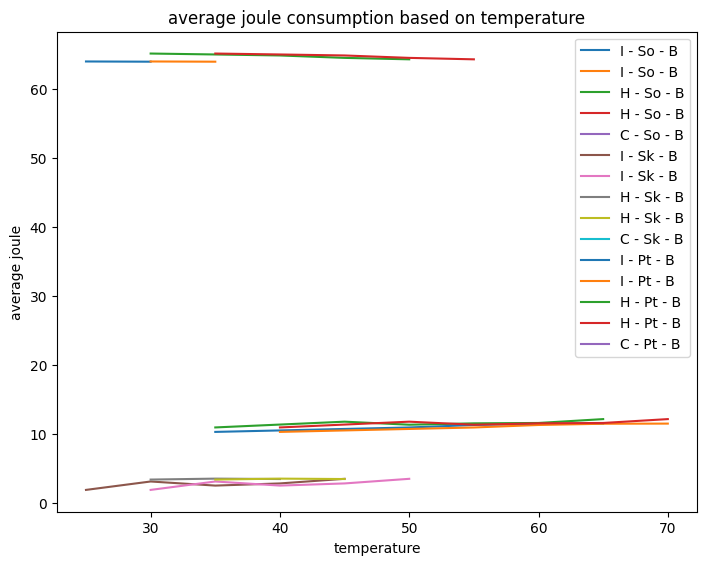

In [225]:
plot_iterations(core_total, get_buckets, is_correct_temperature, "temperature", "average joule", "average joule consumption based on temperature")

In [222]:
def is_correct_charge(exp, value):
    min_value = value[0]
    max_value = value[1]
    
    temp = [x.value for x in exp.start_battery.data]
    
    if len(temp) == 0:
        return False
    
    avg_temp = sum(temp) / len(temp)
    
    return avg_temp > min_value and avg_temp < max_value

(95, 100) - Surface4Pro, BinaryTrees, Win32NT, IntelPowerGadget - sum of 9 (10.320024392826387 - 11.659546339642256)
(95, 100) - Surface4Pro, BinaryTrees, Win32NT, HardwareMonitor - sum of 9 (11.256884478947818 - 11.688151577005522)
(95, 100) - SurfaceBook, BinaryTrees, Win32NT, IntelPowerGadget - sum of 9 (2.244484755434248 - 2.962013589015756)
(95, 100) - SurfaceBook, BinaryTrees, Win32NT, HardwareMonitor - sum of 9 (2.927467625071134 - 3.896659141983243)


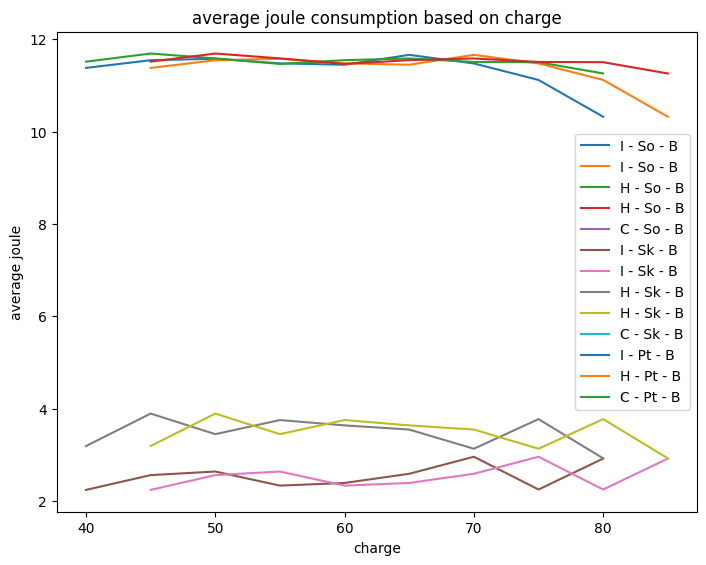

In [223]:
plot_iterations(core_total, get_buckets, is_correct_charge, "charge", "average joule", "average joule consumption based on charge")
